In [1]:
### Second part of the project: Making a seq2seq model and test the model on CNN data.
import os, sys
import csv
csv.field_size_limit(sys.maxsize)
import string
import torchtext
import spacy
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data_util

not_twice = False # Parameter for only loading data once

## Use this to mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
os.chdir("/content/gdrive/My Drive/Deep Learning/VJ_og_AH/Data")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## Functions for making Cuda available
def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if torch.cuda.is_available():
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if torch.cuda.is_available():
        return x.cpu().data.numpy()
    return x.data.numpy()

In [3]:
# Script for loading and preparing data from .stories 

# Defining function for loading data
def load_data(data_file):
    file = open(data_file, encoding='utf-8') 
    text = file.read()
    file.close()
    return text
        
# Function to split the data into data chunks and highligts
def split_data(text):
    idx = text.find("@highlight")
    chunk, highlights = text[:idx], text[idx:].split("@highligt")
    highlights = [h.strip() for h in highlights if len(h) > 0]    # Strip white space around highlights
    return chunk, highlights

# Defining function for iterating through many files in the same directory (direc_name = full directory name)
def load_files(direc_name):
    data_pairs = list()
    for single_file in os.listdir(direc_name):
        file_name = direc_name + "/" + single_file
        text = load_data(file_name)
        story, highlights = split_data(text)
        data_pairs.append({"Story":story,"Highlights":highlights})
    return data_pairs

## Cleaning the data 
# clean a list of lines
def clean_lines(lines,max_length,change_punctuation=False):
    max_line = 0
    cleaned = list()
    # prepare a translation table to remove punctuation
    #table = str.maketrans('', '', string.punctuation)
    for line in lines:
        # If line is empty -> skip to next line
        if not line:
            continue
        # strip source cnn office if it exists
        index = line.find('(CNN)')
        if index > -1:
            line = line[index+len('(CNN) --'):]
        # tokenize (really split() on white spaces?) on white space
        line = line.split()
        if change_punctuation:
            line = ["." if x=="@highlight" else x for x in line]
            if line[0]==".":
                del(line[0])
        max_line += len(line)
        # convert to lower case
        line = [word.lower() for word in line]
        # store as string
        cleaned.append(' '.join(line))
    if change_punctuation:
        cleaned[0] = cleaned[0].replace(" .",".")
    if max_line > max_length:
        max_length = max_line
    cleaned = [" ".join(cleaned)]
    return cleaned, max_length

if os.path.isfile('/content/gdrive/My Drive/Deep Learning/VJ_og_AH/Data/cnn_dataset_full.pkl'):  # If there is already a pickle -> load pickle
    # load from file
    data_pairs = pickle.load(open('/content/gdrive/My Drive/Deep Learning/VJ_og_AH/Data/cnn_dataset_full.pkl', 'rb'))
    print('Loaded Data Pairs %d' % len(data_pairs))  # Last time it was 20443
    max_length_story = 400
    max_length_high = 100
else:   # If there is not a pickle -> load data and write pickle
    direc = "/content/gdrive/My Drive/Deep Learning/VJ_og_AH/Data/cnn/stories"
    data_pairs = load_files(direc)
    # clean stories
    max_length_story = 0
    max_length_high = 0
    for num,example in enumerate(data_pairs):
        example['Story'],max_length_story = clean_lines(example['Story'].split('\n'),
                                                        max_length_story)
        example['Highlights'],max_length_high = clean_lines(example['Highlights'],
                                                       max_length_high,change_punctuation=True)
    print("Length of dataset is {}".format(len(data_pairs)))
    print(max_length_story)
    print(max_length_high)
    # save to file
    pickle.dump(data_pairs, open('cnn_dataset.pkl', 'wb'))
    
print(data_pairs[1]["Story"])
print(data_pairs[1]["Highlights"])


Loaded Data Pairs 92579
['usain bolt rounded off the world championships sunday by claiming his third gold in moscow as he anchored jamaica to victory in the men\'s 4x100m relay. the fastest man in the world charged clear of united states rival justin gatlin as the jamaican quartet of nesta carter, kemar bailey-cole, nickel ashmeade and bolt won in 37.36 seconds. the u.s finished second in 37.56 seconds with canada taking the bronze after britain were disqualified for a faulty handover. the 26-year-old bolt has now collected eight gold medals at world championships, equaling the record held by american trio carl lewis, michael johnson and allyson felix, not to mention the small matter of six olympic titles. the relay triumph followed individual successes in the 100 and 200 meters in the russian capital. "i\'m proud of myself and i\'ll continue to work to dominate for as long as possible," bolt said, having previously expressed his intention to carry on until the 2016 rio olympics. vict

In [0]:
def create_dataloader(data_pairs, load_data, vocab_size):
    # Initiating fields for torchtext data handling
    en = spacy.load('en_core_web_sm')   # Load spacy's english 
    def tokenize_en(sentence):
        return [tok.text for tok in en.tokenizer(sentence)]

    Story_TEXT = torchtext.data.Field(tokenize=tokenize_en,fix_length=max_length_story)

    Highlights_TEXT = torchtext.data.Field(tokenize=tokenize_en, fix_length=max_length_high,
                                          init_token = "<sos>", eos_token = "<eos>")
    
    # If CSV files are present in the folder then skip this
    if load_data == False:
        df = pd.DataFrame(data_pairs,columns=["Story","Highlights"])

        # Create a small training and test set for practice 
        #small_set,_ = train_test_split(df, test_size=2)
        train,val = train_test_split(df, test_size=0.1)

        # Preparing CSV for torchtext
        train.to_csv("train_.csv", index=False)
        val.to_csv("val_.csv", index=False)
    
        # Associate the text in the 'Story' column with the Story_TEXT field and 'Highlights' with Highlights_TEXT
        data_fields = [('Story', Story_TEXT), ('Highlights', Highlights_TEXT)]
        train,val = torchtext.data.TabularDataset.splits(path='./', train='train_AH.csv',
                                                        validation='val_AH.csv',
                                                        format='csv', fields=data_fields)  
        
        # Building the vocabulary
        Highlights_TEXT.build_vocab(train.Story, train.Highlights, min_freq=1) # min_freq defines the minimum occurency of a word for it to be included in the vocab
        Story_TEXT.vocab = Highlights_TEXT.vocab
        vocab_model = Story_TEXT.vocab.itos[0:vocab_size]

    else: 
        if os.path.isfile('val_AH.csv') == False or os.path.isfile('train_AH.csv') == False:
            raise Exception("CSV file(s) are not present in the current folder")
        # Associate the text in the 'Story' column with the Story_TEXT field and 'Highlights' with Highlights_TEXT
        data_fields = [('Story', Story_TEXT), ('Highlights', Highlights_TEXT)]
        train,val = torchtext.data.TabularDataset.splits(path='./', train='train_AH.csv',
                                                        validation='val_AH.csv',
                                                        format='csv', fields=data_fields) 

    # Making the iterator for training
    batch_size = 16
    train_loader = torchtext.data.BucketIterator(train, batch_size=batch_size,
                                              shuffle=True,repeat=False)
    val_loader = torchtext.data.BucketIterator(val, batch_size=batch_size,
                                              shuffle=True,repeat=False)
    
    not_twice = True
    
    return train_loader, val_loader, Story_TEXT, Highlights_TEXT, batch_size, not_twice 

In [0]:
## Creating a seq2seq network
def create_networks(hidden_size, vocab_size, input_length):
    class Encoder(nn.Module):
        def __init__(self,hidden_size,input_size,bidirectional,maximum_length = input_length):
            super(Encoder,self).__init__()
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.input_length = input_length
            self.bidirectional = bidirectional

            self.embedding = nn.Embedding(input_size,hidden_size)
            
            self.encoder = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, bidirectional=bidirectional)  
            
        def forward(self,x,hidden,Story_TEXT):

            batch_padding = self.input_length - (x == Story_TEXT.vocab.stoi["<pad>"]).sum(dim=0)

            embedded_input = self.embedding(x)

            pack_padded_inp  = nn.utils.rnn.pack_padded_sequence(embedded_input, batch_padding, enforce_sorted = False)

            packed_output, ht = self.encoder(pack_padded_inp,hidden)

            output,_ = nn.utils.rnn.pad_packed_sequence(packed_output,padding_value=Story_TEXT.vocab.stoi["<pad>"],
                                                      total_length= input_length)
            
            outputs = output[:, :, :self.hidden_size] + output[:, : ,self.hidden_size:]
            ht = (ht[0, :, :] + ht[1, : ,:]).unsqueeze(0)

            return outputs, ht
          
    # Defining parameters for attention decoder
    class AttnDecoderRnn(nn.Module):
        def __init__(self, hidden_size, output_size, input_vocab_size, bidirectional, dropout_p=0.1, maximum_length = input_length):
            super(AttnDecoderRnn, self).__init__()

            self.hidden_size = hidden_size
            self.output_size = output_size
            #self.dropout_p = dropout_p
            self.input_vocab_size = input_vocab_size
            self.input_length = maximum_length
            self.bidirectional = bidirectional

            if bidirectional == True:
                factor = 2
            else: 
                factor = 1

            #self.dropout_lin = nn.Dropout(dropout_p)

            self.embedding = nn.Embedding(input_vocab_size,hidden_size)

            self.decoder = nn.GRU(hidden_size, hidden_size, bidirectional=bidirectional)

            self.W_out_enc = nn.Linear(hidden_size*factor,hidden_size*factor,bias=False)
            self.W_hidden = nn.Linear(hidden_size*factor,hidden_size*factor)
            self.W_vector = nn.Linear(hidden_size*factor,1,bias=False)

            self.lin_1 = nn.Linear(hidden_size*2*factor,output_size) 
            
        def forward(self, input_var, hidden, encoder_output): # uses decoder's input and hidden state as input.

            embedded_input = self.embedding(input_var)

            _, hidden_decoder = self.decoder(embedded_input,hidden)

            awob = self.W_out_enc(encoder_output)
            awb = self.W_hidden(hidden_decoder)
            e_i = self.W_vector(torch.tanh(awob + awb))

            attn_dist = F.softmax(e_i,dim=0)
            context_vector = torch.matmul(attn_dist.permute(1,2,0),encoder_output.permute(1,0,2))

            out_lin_1 = self.lin_1(torch.cat((hidden_decoder,context_vector.permute(1,0,2)),2))

            return out_lin_1[0], hidden_decoder, attn_dist

    def weight_initialization(m):
        if type(m)==nn.Linear:
            init.xavier_uniform_(m.weight)

    net_enc = Encoder(hidden_size,vocab_size,bidirectional=True)
    net_dec = AttnDecoderRnn(hidden_size,vocab_size,vocab_size,bidirectional=False)

    net_dec.apply(weight_initialization)

    if torch.cuda.is_available():
        print('##converting networks to cuda-enabled')
        net_enc.cuda()
        net_dec.cuda()

    print(net_enc)
    print(net_dec)
          
    numbers = 0
    for param in net_enc.parameters():
        numbers += torch.numel(param)
    print("Number of parameters in encoder: {}".format(numbers))
    for param in net_dec.parameters():
        numbers += torch.numel(param)
    print("Number of parameters in networks: {}".format(numbers))

    return net_enc, net_dec


In [0]:
## Defining loss function and optimizer
def create_LF_OP(learning_rate, padding_idx,net_enc,net_dec):
    class_weights = get_variable(torch.ones(vocab_size))   # Constructed to ignore padding 
    class_weights[padding_idx] = 0

    LEARNING_RATE = learning_rate
    criterion = nn.CrossEntropyLoss(weight=class_weights)        

    optim_net_enc = optim.Adam(net_enc.parameters(), lr=LEARNING_RATE)
    optim_net_dec = optim.Adam(net_dec.parameters(), lr=LEARNING_RATE)

    return criterion, optim_net_enc, optim_net_dec

In [0]:
def training_loop(ep_check,epochs,max_length_story, max_length_high,batch_size,
                  hidden_size,vocab_size,plot_loss,batch_counter,Highlights_TEXT,
                  Story_TEXT,vocab_model,net_enc,net_dec,criterion,optim_net_enc,
                  optim_net_dec,train_loader):  
    net_enc.train()
    net_dec.train()   
    ## Training the network
    for ep in range(ep_check,ep_check+epochs):  
        train_loss = 0
        train_loader.init_epoch()
        for batch_num, train_data in enumerate(train_loader):
            # Clearing variables to allow for different lenght inputs
            t0 = time.time()
            input_encoder = []
            input_decoder = []
            output_encoder = []
            output_decoder = []
            barack_search = 0
            print_out = list()
            print_target = list()
            loss = 0      # Resetting loss
            optim_net_enc.zero_grad()
            optim_net_dec.zero_grad()
            
            if train_data.Story.size() != torch.Size([max_length_story, batch_size]):
                continue
        
            hidden_encoder = get_variable(torch.zeros(2,batch_size,hidden_size)) # Initializing first hidden state of encoder
          
            input_encoder = get_variable(train_data.Story.long()) # Getting a training sample
            targets = get_variable(train_data.Highlights.permute(1,0).long())  # Getting corresponding target sample

            input_encoder[input_encoder>(vocab_size-1)] = 0
            targets[targets>(vocab_size-1)] = 0        
            
            output_encoder , hidden_encoder = net_enc(input_encoder,hidden_encoder,Story_TEXT) 
            hidden_decoder = hidden_encoder     # Getting the last hidden vector = input for the decoder
            
            input_decoder = get_variable(train_data.Highlights[0,:].long()) # Initializing start value for decoder corresponding to "SOS"

            t1 = time.time()
            for itera in range(max_length_high-1):     # Teacher forced learning
                output_decoder, hidden_decoder, attn_dist_ex = net_dec(torch.unsqueeze(input_decoder,0),
                                                                  hidden_decoder, output_encoder)
                input_decoder = get_variable(torch.tensor([target[itera+1].item() for target in targets]).long())
                            
                loss += criterion(get_variable(output_decoder),get_variable(input_decoder))

                idx = torch.argmax(output_decoder[0])
                print_out.append(Highlights_TEXT.vocab.itos[idx])
                print_target.append(Highlights_TEXT.vocab.itos[input_decoder[0]])
            t2 = time.time()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(net_enc.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(net_dec.parameters(), 1.0)
            optim_net_enc.step()
            optim_net_dec.step()
            
            train_loss += loss.item()    
            t3 = time.time()
            if batch_num % 100 == 0 and batch_num > 1: 
                print("Training batch number {0} in epoch number {1} with average batch training error {2}".format(batch_num,ep+1,train_loss/100))
                plot_loss.append(train_loss/100)
                train_loss = 0
                print(print_out)
                print(print_target)     
                print("Encoder section: {}. Decoder section: {}. Backpropagation section: {}.".format(t1-t0,t2-t1,t3-t2))

        print("Epoch number {} with average batch training error {}".format(ep+1,train_loss/(batch_num+1)))

        torch.save({
            'epoch': ep+1,
            'model_state_dict_enc': net_enc.state_dict(),
            'model_state_dict_dec': net_dec.state_dict(),
            'optimizer_state_dict_enc': optim_net_enc.state_dict(),
            'optimizer_state_dict_dec': optim_net_dec.state_dict(),
            'batch_counter': batch_counter,
            'plot_loss': plot_loss,
            'vocab_high': Highlights_TEXT.vocab,
            'vocab_story': Story_TEXT.vocab,
            }, 'checkpoint_Al_10_2.1_EP' + str(ep+1) + '.pth.tar')
        
        print("Epoch number: {}".format(ep+1))


def validation_loop(percent_files,net_enc,net_dec,val_loader,max_length_high ,batch_size, vocab_size,
                        max_length_story,hidden_size,Story_TEXT,Highlights_TEXT):
    net_enc.eval()
    net_dec.eval()
    with torch.no_grad():
        for batch_num, val_data in enumerate(val_loader):
            # Clearing variables to allow for different lenght inputs
            input_encoder = []
            input_decoder = []
            print_output = torch.empty(max_length_high ,batch_size, vocab_size)
            output_encoder = []
            output_decoder = []
            summary = []
            reference = []
            story = []
            loss = 0      # Resetting loss
            
            if val_data.Story.size() != torch.Size([max_length_story, batch_size]):
                continue

            hidden_encoder = get_variable(torch.zeros(2,batch_size,hidden_size)) # Initializing first hidden state of encoder
          
            input_encoder = get_variable(val_data.Story.long()) # Getting a training sample
            targets = get_variable(val_data.Highlights.permute(1,0).long())  # Getting corresponding target sample
            
            input_encoder[input_encoder>(vocab_size-1)] = 0
            targets[targets>(vocab_size-1)] = 0

            output_encoder, hidden_encoder = net_enc(input_encoder, hidden_encoder, Story_TEXT) 
            hidden_decoder = hidden_encoder     # Getting the context vector = input for the decoder

            input_decoder = get_variable(val_data.Highlights[0,:].long()) # Initializing start value for decoder corresponding to "SOS"

            for itera in range(max_length_high-1):
                output_decoder, hidden_decoder, weights = net_dec(torch.unsqueeze(input_decoder,0),
                                                                  hidden_decoder, output_encoder)
                
                input_decoder = get_variable(torch.tensor([torch.argmax(target).item() for target in output_decoder]).long())

                print_output[itera] = output_decoder

            if batch_num % 50 == 0: 
                print("Validation batch number {0}".format(batch_num))
            
            random_num = np.random.uniform()
            if random_num > (1-percent_files):
                for sentence in range(batch_size):
                    for do in range(max_length_story):
                        story.append(Story_TEXT.vocab.itos[val_data.Story[do][sentence]])
                    story = list(filter(lambda a: a != "<pad>", story))
                    story = " ".join(story)
                    sto = open("/content/gdrive/My Drive/Deep Learning/VJ_og_AH/Data/stories/story"  + str(batch_num) + str(sentence+1) + ".txt",'w+')  # Opening a file in write mode automatically clears previous context
                    sto.write(story)
                    sto.close
                    story = []

                for sentence in range(batch_size):       # Preparing data for rouge score
                    for do in range(len(targets[0])):
                        softies = F.softmax(print_output[do][sentence], dim=0)
                        val, ind = torch.max(softies,dim=0)
                        summary.append(Story_TEXT.vocab.itos[ind])
                        reference.append(Highlights_TEXT.vocab.itos[val_data.Highlights.permute(1,0)[sentence][do]])
                    if "<eos>" in summary:
                        eos_idx = summary.index("<eos>")
                        summary = summary[0:eos_idx]
                    while "<unk>" in summary:
                        unk_idx = summary.index("<unk>")
                        summary[unk_idx] = "unk"
                    while "<unk>" in reference:
                        unk_idx = reference.index("<unk>")
                        reference[unk_idx] = "unk"
                    reference = list(filter(lambda a: a != "<pad>", reference))
                    reference = list(filter(lambda a: a != "<sos>", reference))
                    reference = list(filter(lambda a: a != "<eos>", reference))
                    if sentence == 0:
                        print(summary)
                        print(reference)
                    summary = " ".join(summary)
                    reference = " ".join(reference)
                    sum = open("/content/gdrive/My Drive/Deep Learning/VJ_og_AH/Data/summaries/summary.A." + str(batch_num) + str(sentence+1) + ".txt","w+")  # Opening a file in write mode automatically clears previous context
                    ref = open("/content/gdrive/My Drive/Deep Learning/VJ_og_AH/Data/reference/reference." + str(batch_num) + str(sentence+1) + ".txt","w+")
                    sum.write(summary)
                    ref.write(reference)
                    sum.close()
                    ref.close()
                    summary = []
                    reference = []

  

In [0]:
def train_error(plot_loss):
    # Making a plot over the training error
    import matplotlib.pyplot as plt
    batch_counter = np.linspace(0,30,len(plot_loss))
    plt.figure()
    plt.plot(batch_counter, plot_loss, 'r', label='Training loss',)
    plt.legend()
    plt.xlabel("Epoch Number"),plt.ylabel("Training error")
    plt.title("Training Error with Adam Optimizer")
    plt.show
    plt.savefig('Training_Error')
    #print(len(plot_loss)/32)
    print(np.mean(plot_loss[1330:]))


In [0]:
def where_the_magic_happens(use_saved,model_file,vocab_size,hidden_size, learning_rate,
                      training_epochs, train_session, val_session, percent_files,
                      train_loader, val_loader, Story_TEXT, Highlights_TEXT, batch_size, print_plot):    
    # Defining parameters for network or loading save
    epochs = training_epochs
    plot_loss = []
    batch_counter = 0
    ep = 0

    if use_saved == True:
        checkpoint = torch.load(model_file)
        ep_check = checkpoint['epoch']
        plot_loss = checkpoint['plot_loss']
        batch_counter = checkpoint["batch_counter"]
        Highlights_TEXT.vocab = checkpoint['vocab_high']
        Story_TEXT.vocab = checkpoint['vocab_story']
        vocab_model = Story_TEXT.vocab.itos[0:vocab_size]

        net_enc,net_dec = create_networks(hidden_size, vocab_size, max_length_story)
        net_enc.load_state_dict(checkpoint['model_state_dict_enc'])
        net_dec.load_state_dict(checkpoint['model_state_dict_dec'])
        criterion, optim_net_enc, optim_net_dec = create_LF_OP(learning_rate, Highlights_TEXT.vocab.stoi["<pad>"],net_enc,net_dec)
        optim_net_enc.load_state_dict(checkpoint['optimizer_state_dict_enc'])    
        optim_net_dec.load_state_dict(checkpoint['optimizer_state_dict_dec'])

    # Chosing training or validation
    if train_session == True:
        training_loop(ep_check,epochs,max_length_story, max_length_high,batch_size,hidden_size,vocab_size,plot_loss,batch_counter,Highlights_TEXT,Story_TEXT,
                      vocab_model,net_enc,net_dec,criterion,optim_net_enc,optim_net_dec,train_loader)
    elif val_session == True:
        validation_loop(percent_files,net_enc,net_dec,val_loader,max_length_high ,batch_size, vocab_size,
                        max_length_story,hidden_size,Story_TEXT,Highlights_TEXT)
    elif print_plot == True:
        train_error(plot_loss)
    else:
        print("Script done")


In [10]:
use_saved = True
model_file = "checkpoint_Al_10_2.1_EP30.pth.tar"
vocab_size = 50000  # Not a changeable parameter with loaded data. 
hidden_size = 256 # Not a changeable parameter with loaded data. 
learning_rate = 0.001  # Not a changeable parameter with loaded data. 
training_epochs = 10
train_session = True
val_session = False
print_plot = False
percent_files = 0.02
if not_twice == False:
    print("Loading Data")
    train_loader, val_loader, Story_TEXT, Highlights_TEXT, batch_size, not_twice = create_dataloader(data_pairs, use_saved, vocab_size)
    print("Data Loaded")
where_the_magic_happens(use_saved, model_file, vocab_size, hidden_size, learning_rate,
                  training_epochs, train_session, val_session, percent_files,
                  train_loader, val_loader, Story_TEXT, Highlights_TEXT, batch_size, print_plot)

Loading Data
Data Loaded
##converting networks to cuda-enabled
Encoder(
  (embedding): Embedding(50000, 256)
  (encoder): GRU(256, 256, bidirectional=True)
)
AttnDecoderRnn(
  (embedding): Embedding(50000, 256)
  (decoder): GRU(256, 256)
  (W_out_enc): Linear(in_features=256, out_features=256, bias=False)
  (W_hidden): Linear(in_features=256, out_features=256, bias=True)
  (W_vector): Linear(in_features=256, out_features=1, bias=False)
  (lin_1): Linear(in_features=512, out_features=50000, bias=True)
)
Number of parameters in encoder: 13589504
Number of parameters in networks: 52565840
Training batch number 100 in epoch number 31 with average batch training error 119.1787387084961
['[', "'", 'police', 'occurred', 'when', 'incident', 'chief', 'to', 'complaints', 'about', 'protests', '-', 'air', 'drug', 'sales', '.', 'property', '.', 'police', 'police', 'were', 'been', 'arrested', ',', 'viola', '<unk>', ',', '.', 'for', '.', 'police', 'say', '.', 'police', 'shows', 'young', 'man', 'out',

KeyboardInterrupt: ignored

137
israel\
tensor([   14,   277,     9,  4800, 13044], device='cuda:0')
tensor([58, 57, 49,  5, 35])
obama
barack
presidential
john
berlin
[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]
[tensor(0.0321, grad_fn=<SelectBackward>), tensor(0.0503, grad_fn=<SelectBackward>), tensor(0.0116, grad_fn=<SelectBackward>), tensor(9.8516e-06, grad_fn=<SelectBackward>), tensor(0.0001, grad_fn=<SelectBackward>), tensor(0.0016, grad_fn=<SelectBackward>), tensor(0.0006, grad_fn=<SelectBackward>), tensor(0.0143, grad_fn=<SelectBackward>), tensor(0.0011, grad_fn=<SelectBackward>), tensor(0.0829, grad_fn=<SelectBackward>), tensor(0.0924, grad_fn=<SelectBackward>), tensor(0.0011, grad_fn=<SelectBackward>), tensor(0.0005, grad_fn=<SelectBackward>), tensor(0.0004, grad_fn=<SelectBackward>), tensor(0.0004, grad_fn=<SelectBackward>), tensor(0.0026, grad_fn=<SelectBackward>), tensor(4.2326e-05, grad_fn=<SelectBackward>), tensor(0.0019, grad_fn=<SelectBackward>), tensor(0.0015,

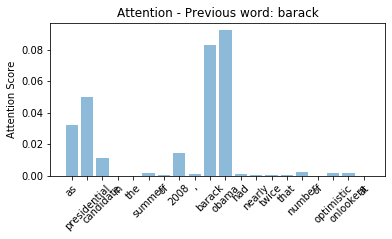

In [0]:
# Histogram of attention. First part should be moved into the trainingloop(). Second part is for constructing the histogram
if barack_search == 0:
    for bat in range(batch_size):
        if Highlights_TEXT.vocab.itos[targets[bat][itera].item()] == "barack":
            attn_barack = attn_dist_ex.permute(1,2,0).squeeze()
            barack_search = attn_barack[bat]
            barack_story = input_encoder[:,bat]
            print("yyyyyeeeehaaaaa")

print(Highlights_TEXT.vocab.stoi["obama"])
print(Highlights_TEXT.vocab.itos[3592])
print(barack_story[62:67])
values, indices = torch.topk(barack_search,5)
print(indices)
for i in range(5):
    print(Highlights_TEXT.vocab.itos[barack_story[indices[i]]])

barack = [barack_story,barack_search]
pickle.dump(barack, open('barack_search.pkl', 'wb'))


bardas = list(range(indices[0]-10,indices[0]+10))
print(bardas)
words = []
valius = []
for i in range(len(bardas)):
    words.append(Highlights_TEXT.vocab.itos[barack_story[bardas[i]]])
    valius.append(barack_search[bardas[i]])
print(valius)

plt.bar(bardas, valius, align='center', alpha=0.5)
plt.xticks(bardas, words, rotation=45)
plt.ylabel('Attention Score')
plt.title('Attention - Previous word: {}'.format("barack"))
plt.gcf().subplots_adjust(bottom=0.35)
plt.savefig('attn_barack.png', dpi=400)
plt.show()